# Elo Score Calculation

In [1]:
import re
import os
from collections import defaultdict

In [2]:
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd

In [4]:
# Increase size of plot in jupyter

plt.rcParams["figure.figsize"] = (18,10)

## Summary

- Notebook that calcuates the Elo Score of mice competing over access to a tone associated reward port
- The data is a spreadsheet of combination of subjects (as rows) against dates (as columns)

## Importing Data

- The original data has been trimmed so that only the cells with dates, winner ID's, and relevant metadata were kept

In [5]:
tube_test_df = pd.read_csv("../../data/tube_test_fights.csv")

In [6]:
tube_test_df.head()

,cage,animal,25-Apr,26-Apr,27-Apr,28-Apr,29-Apr,2-May,4-May,5-May,6-May,9-May,10-May,11-May,12-May,13-May,20-May
0,1,1.1 v 2.2,1.1,1.1,1.1,2.2,1.1,1.1,NaN,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1
1,1,2.2 v 2.3,2.2,2.3,2.2,2.2,2.2,2.2,NaN,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2
2,1,2.3 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,NaN,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
3,1,1.4 v 1.1,1.4,1.4,1.4,1.4,1.4,1.4,NaN,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
4,1,2.2 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,NaN,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4


## Doing it for a subset of the data

- To test out the code, we will be using the data from only one cage

In [7]:
# Getting all the rows that are from cage 1
cage_1_df = tube_test_df[tube_test_df["cage"] == 1]

In [8]:
cage_1_df

,cage,animal,25-Apr,26-Apr,27-Apr,28-Apr,29-Apr,2-May,4-May,5-May,6-May,9-May,10-May,11-May,12-May,13-May,20-May
0,1,1.1 v 2.2,1.1,1.1,1.1,2.2,1.1,1.1,NaN,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1
1,1,2.2 v 2.3,2.2,2.3,2.2,2.2,2.2,2.2,NaN,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2
2,1,2.3 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,NaN,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
3,1,1.4 v 1.1,1.4,1.4,1.4,1.4,1.4,1.4,NaN,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
4,1,2.2 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,NaN,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
5,1,1.1 v 2.3,2.3,1.1,1.1,1.1,1.1,1.1,NaN,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1


## Getting a list of all the animals

- Because each cell does not contain the ID of all the animals that were competing, we will make a new column with both ID's

In [9]:
def get_all_animal_ids(animal_string):
    """
    Converts a string that contains the ID of animals, and only gets the IDs. 
    This usually removes extra characters that were added. (i.e. "1.1 v 2.2" to ("1.1", "2.2"))

    Args:
        animal_string(str): This is the first param.

    Returns:
        tuple: Of IDs of animals as strings
    """
    # Splitting by space so that we have a list of just the words
    all_words = animal_string.split()
    # Removing all words that are not numbers
    all_numbers = [num for num in all_words if re.match(r'^-?\d+(?:\.\d+)$', num)]
    return tuple(all_numbers)


In [10]:
print(get_all_animal_ids("1.1 v 2.3"))

('1.1', '2.3')


- Turning all the columns into string so that we can match the ID's from one column to another

In [11]:
for col in cage_1_df.columns:
    cage_1_df[col] = cage_1_df[col].astype(str)

/tmp/ipykernel_183766/4260518769.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cage_1_df[col] = cage_1_df[col].astype(str)


In [12]:
cage_1_df.head()

,cage,animal,25-Apr,26-Apr,27-Apr,28-Apr,29-Apr,2-May,4-May,5-May,6-May,9-May,10-May,11-May,12-May,13-May,20-May
0,1,1.1 v 2.2,1.1,1.1,1.1,2.2,1.1,1.1,nan,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1
1,1,2.2 v 2.3,2.2,2.3,2.2,2.2,2.2,2.2,nan,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2
2,1,2.3 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
3,1,1.4 v 1.1,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4
4,1,2.2 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4


In [13]:
cage_1_df["all_animals"] = cage_1_df["animal"].apply(lambda x: get_all_animal_ids(x))

/tmp/ipykernel_183766/1018194899.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cage_1_df["all_animals"] = cage_1_df["animal"].apply(lambda x: get_all_animal_ids(x))


In [14]:
cage_1_df.head()

,cage,animal,25-Apr,26-Apr,27-Apr,28-Apr,29-Apr,2-May,4-May,5-May,6-May,9-May,10-May,11-May,12-May,13-May,20-May,all_animals
0,1,1.1 v 2.2,1.1,1.1,1.1,2.2,1.1,1.1,nan,1.1,1.1,1.1,1.1,1.1,1.1,1.1,1.1,"(1.1, 2.2)"
1,1,2.2 v 2.3,2.2,2.3,2.2,2.2,2.2,2.2,nan,2.2,2.2,2.2,2.2,2.2,2.2,2.2,2.2,"(2.2, 2.3)"
2,1,2.3 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,"(2.3, 1.4)"
3,1,1.4 v 1.1,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,"(1.4, 1.1)"
4,1,2.2 v 1.4,1.4,1.4,1.4,1.4,1.4,1.4,nan,1.4,1.4,1.4,1.4,1.4,1.4,1.4,1.4,"(2.2, 1.4)"


## Elo Score Calculation

In [15]:
def calculate_elo_score(subject_elo_score, agent_elo_score, k_factor=20, score=1, number_of_decimals=None):
    """
    Calculates the Elo score of a given subject given it's original score, it's opponent, 
    the K-Factor, and whether or not it has won or not. 
    The calculation is based on: https://www.omnicalculator.com/sports/elo

    Args:
        subject_elo_score(float): The original Elo score for the subject
        agent_elo_score(float): The original Elo score for the agent
        k_factor(int): k-factor, or development coefficient. 
            - It usually takes values between 10 and 40, depending on player's strength 
        score(int): the actual outcome of the game. 
            - In chess, a win counts as 1 point, a draw is equal to 0.5, and a lose gives 0.
        number_of_decimals(int): Number of decimals to round to
        
    Returns:
        int: Updated Elo score of the subject
    """
    # Calculating the Elo score
    rating_difference = agent_elo_score - subject_elo_score
    expected_score = 1 / (1 + 10 ** (rating_difference / 400))
    new_elo_score = subject_elo_score + k_factor * (score - expected_score)
    # Rounding to `number_of_decimals`
    return round(new_elo_score, number_of_decimals)

# Calculate Elo Score Urine Marking Assay

In [16]:
urine_marking_assay_df = pd.read_excel("../../data/Pilot of Pilot Consolidation.xlsx", sheet_name="Urine Marking Assay")

In [17]:
urine_marking_assay_df["date_str"] = urine_marking_assay_df["Date"].astype(str)

In [18]:
urine_marking_assay_df["winner_str"] = urine_marking_assay_df["Winner"].astype(str).apply(lambda x: x.strip())

In [19]:
urine_marking_assay_df.head()

,Date,CAGE,Match,Winner,date_str,winner_str
0,2022-05-18,3,4.1 (1) v 3.2 (2),3.2 (2),2022-05-18,3.2 (2)
1,2022-05-18,3,4.2 (3) v 3.3 (4),4.2 (3),2022-05-18,4.2 (3)
2,2022-05-18,4,3.1 (1) v 3.4 (2),3.1 (1),2022-05-18,3.1 (1)
3,2022-05-18,4,4.3 (3) v 4.4 (4),4.4 (4),2022-05-18,4.4 (4)
4,2022-05-19,3,4.1 (1) v 3.2 (2),4.1 (1),2022-05-19,4.1 (1)


# Calculate Elo score for all cells

- Getting all the ID's of the animals

In [20]:
# Splitting by "v" and stripping all the spaces
urine_marking_assay_df["all_animals"] = urine_marking_assay_df["Match"].apply(lambda x: tuple([animal.strip() for animal in x.split("v")]))

In [21]:
urine_marking_assay_df.head(n=25)

,Date,CAGE,Match,Winner,date_str,winner_str,all_animals
0,2022-05-18,3,4.1 (1) v 3.2 (2),3.2 (2),2022-05-18,3.2 (2),"(4.1 (1), 3.2 (2))"
1,2022-05-18,3,4.2 (3) v 3.3 (4),4.2 (3),2022-05-18,4.2 (3),"(4.2 (3), 3.3 (4))"
2,2022-05-18,4,3.1 (1) v 3.4 (2),3.1 (1),2022-05-18,3.1 (1),"(3.1 (1), 3.4 (2))"
3,2022-05-18,4,4.3 (3) v 4.4 (4),4.4 (4),2022-05-18,4.4 (4),"(4.3 (3), 4.4 (4))"
4,2022-05-19,3,4.1 (1) v 3.2 (2),4.1 (1),2022-05-19,4.1 (1),"(4.1 (1), 3.2 (2))"
5,2022-05-19,3,4.2 (3) v 3.3 (4),tie,2022-05-19,tie,"(4.2 (3), 3.3 (4))"
6,2022-05-19,4,3.1 (1) v 3.4 (2),3.4 (2),2022-05-19,3.4 (2),"(3.1 (1), 3.4 (2))"
7,2022-05-19,4,4.3 (3) v 4.4 (4),4.4 (4),2022-05-19,4.4 (4),"(4.3 (3), 4.4 (4))"
8,2022-05-19,1,1.1 v 2.3,1.1,2022-05-19,1.1,"(1.1, 2.3)"
9,2022-05-19,1,2.2 v 1.4,1.4,2022-05-19,1.4,"(2.2, 1.4)"


## Get the Elo score for one fight

In [22]:
# Dictionary that keeps track of the current Elo score of the subject
id_to_elo_score = defaultdict(lambda:1000)

index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))

# Keeping track of the number of matches
id_to_match_number = defaultdict(lambda:1)
for index, row in urine_marking_assay_df.iterrows():
    # Checking if there is an Nan or not
    if row["winner_str"] == "nan":
        continue
    elif row["winner_str"] == "tie":
        winner_id = row["all_animals"][0]
        loser_id = row["all_animals"][1]
        winner_score = 0.5
        loser_score = 0.5  
    else:            
        winner_id = row["winner_str"]
        # Getting the ID of the loser subject
        loser_id = list(set(row["all_animals"]) - set([winner_id]))
        loser_id = loser_id[0]
        winner_score = 1
        loser_score = 0
        
        
        
        
    date = row["date_str"]
    # Getting the ID of the loser subject
    loser_id = list(set(row["all_animals"]) - set([winner_id]))
    loser_id = loser_id[0]
    # Getting the current Elo Score
    current_winner_rating = id_to_elo_score[winner_id] 
    current_loser_rating = id_to_elo_score[loser_id] 
    # Calculating Elo score            
    id_to_elo_score[winner_id] = calculate_elo_score(subject_elo_score=current_winner_rating, agent_elo_score=current_loser_rating, score=winner_score, number_of_decimals=1)
    id_to_elo_score[loser_id] = calculate_elo_score(subject_elo_score=current_loser_rating, agent_elo_score=current_winner_rating, score=loser_score, number_of_decimals=1)

    # Saving all the data for the winner
    winner_index = next(all_indexes)
    index_to_elo_score_and_meta_data[winner_index]["date"] = date
    index_to_elo_score_and_meta_data[winner_index]["match_number"] = id_to_match_number[date + winner_id]
    index_to_elo_score_and_meta_data[winner_index]["cage"] = row["CAGE"]
    index_to_elo_score_and_meta_data[winner_index]["subject_id"] = winner_id
    index_to_elo_score_and_meta_data[winner_index]["agent_id"] = loser_id
    index_to_elo_score_and_meta_data[winner_index]["original_elo_score"] = current_winner_rating
    index_to_elo_score_and_meta_data[winner_index]["updated_elo_score"] = id_to_elo_score[winner_id]
    index_to_elo_score_and_meta_data[winner_index]["win_draw_loss"] = winner_score


    # Saving all the data for the loser
    loser_index = next(all_indexes)
    index_to_elo_score_and_meta_data[loser_index]["date"] = date
    index_to_elo_score_and_meta_data[loser_index]["match_number"] = id_to_match_number[date + loser_id]
    index_to_elo_score_and_meta_data[loser_index]["cage"] = row["CAGE"]
    index_to_elo_score_and_meta_data[loser_index]["subject_id"] = loser_id
    index_to_elo_score_and_meta_data[loser_index]["agent_id"] = winner_id
    index_to_elo_score_and_meta_data[loser_index]["original_elo_score"] = current_loser_rating
    index_to_elo_score_and_meta_data[loser_index]["updated_elo_score"] = id_to_elo_score[loser_id]
    index_to_elo_score_and_meta_data[loser_index]["win_draw_loss"] = loser_score

    id_to_match_number[date + winner_id] += 1
    id_to_match_number[date + loser_id] += 1
    

In [23]:
id_to_elo_score

defaultdict(<function __main__.<lambda>()>,
            {'3.2 (2)': 999.4,
             '4.1 (1)': 1020.6,
             '4.2 (3)': 978.9,
             '3.3 (4)': 1001.1,
             '3.1 (1)': 1009.0,
             '3.4 (2)': 971.0,
             '4.4 (4)': 1054.6,
             '4.3 (3)': 965.4,
             '1.1': 1028.3,
             '2.3': 963.4,
             '1.4': 1007.2,
             '2.2': 1001.1,
             '2.4': 1000.6,
             '1.2': 962.8,
             '2.1': 1037.2,
             '1.3': 999.4})

In [24]:
index_to_elo_score_and_meta_data[0]

{'date': '2022-05-18',
 'match_number': 1,
 'cage': 3,
 'subject_id': '3.2 (2)',
 'agent_id': '4.1 (1)',
 'original_elo_score': 1000,
 'updated_elo_score': 1010.0,
 'win_draw_loss': 1}

In [25]:
urine_marking_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

In [26]:
urine_marking_elo_score_df.head(n=25)

,date,match_number,cage,subject_id,agent_id,original_elo_score,updated_elo_score,win_draw_loss
0,2022-05-18,1,3,3.2 (2),4.1 (1),1000.0,1010.0,1.0
1,2022-05-18,1,3,4.1 (1),3.2 (2),1000.0,990.0,0.0
2,2022-05-18,1,3,4.2 (3),3.3 (4),1000.0,1010.0,1.0
3,2022-05-18,1,3,3.3 (4),4.2 (3),1000.0,990.0,0.0
4,2022-05-18,1,4,3.1 (1),3.4 (2),1000.0,1010.0,1.0
5,2022-05-18,1,4,3.4 (2),3.1 (1),1000.0,990.0,0.0
6,2022-05-18,1,4,4.4 (4),4.3 (3),1000.0,1010.0,1.0
7,2022-05-18,1,4,4.3 (3),4.4 (4),1000.0,990.0,0.0
8,2022-05-19,1,3,4.1 (1),3.2 (2),990.0,1000.6,1.0
9,2022-05-19,1,3,3.2 (2),4.1 (1),1010.0,999.4,0.0


## Making the Dates into Numbers

In [27]:
# Given timestamp in string
time_str = '2021-7-24'
date_format_str = '%Y-%m-%d'
# create datetime object from timestamp string
given_time = datetime.strptime(time_str, date_format_str)

In [28]:
urine_marking_elo_score_df["date_time"] = urine_marking_elo_score_df["date"].apply(lambda x: datetime.strptime(x, date_format_str))

In [29]:
earliest_date = urine_marking_elo_score_df["date"].min()
latest_date = urine_marking_elo_score_df["date"].max()

In [30]:
earliest_date

'2022-05-18'

In [31]:
latest_date

'2022-06-01'

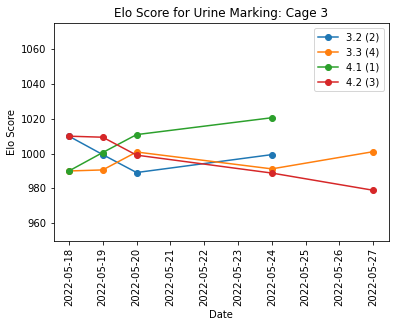

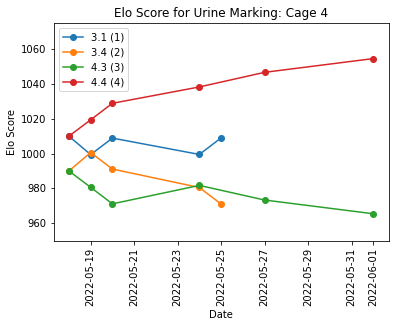

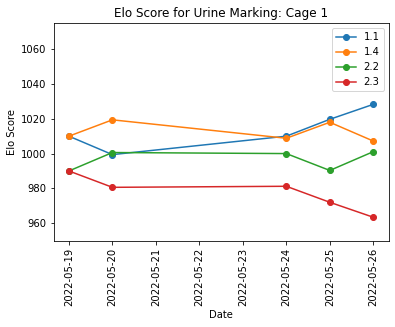

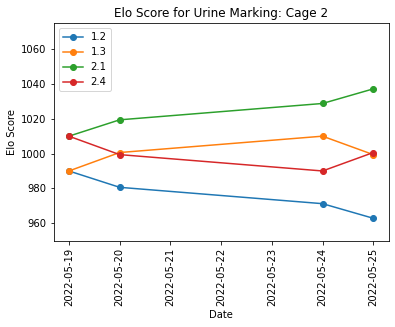

In [40]:
# Plotting for each cage
for cage in urine_marking_elo_score_df["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = urine_marking_elo_score_df[urine_marking_elo_score_df["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in sorted(cage_df["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["date_time"], subject_df["updated_elo_score"], '-o', label=subject)
    
    
    
    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
#     ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Date")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Urine Marking: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(950, 1075) 
    file_name = "urine_marking_elo_score_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
    plt.savefig(os.path.join("./proc/plots/urine_marking", file_name))


In [37]:
all_cages = "_".join(sorted(urine_marking_elo_score_df["cage"].astype(str).unique()))

In [38]:
all_cages

'1_2_3_4'

In [39]:
urine_marking_elo_score_df.to_csv("./proc/urine_marking_elo_scorecage_{}_date_{}_{}.csv".format(all_cages, earliest_date, latest_date))

# Replotting the Matches

In [42]:
# Dictionary that keeps track of the current Elo score of the subject
id_to_elo_score = defaultdict(lambda:1000)

index_to_elo_score_and_meta_data = defaultdict(dict)
# Iterating through each column which is a day
all_indexes = iter(range(0, 99999))

# Keeping track of the number of matches
cage_to_match_number = defaultdict(lambda:0)
for index, row in urine_marking_assay_df.iterrows():
    # Checking if there is an Nan or not
    if row["winner_str"] == "nan":
        continue
    elif row["winner_str"] == "tie":
        winner_id = row["all_animals"][0]
        loser_id = row["all_animals"][1]
        winner_score = 0.5
        loser_score = 0.5  
    else:            
        winner_id = row["winner_str"]
        # Getting the ID of the loser subject
        loser_id = list(set(row["all_animals"]) - set([winner_id]))
        loser_id = loser_id[0]
        winner_score = 1
        loser_score = 0
        
        

        
    date = row["date_str"]
    # Getting the ID of the loser subject
    loser_id = list(set(row["all_animals"]) - set([winner_id]))
    loser_id = loser_id[0]
    # Getting the current Elo Score
    current_winner_rating = id_to_elo_score[winner_id] 
    current_loser_rating = id_to_elo_score[loser_id] 
    # Calculating Elo score            
    id_to_elo_score[winner_id] = calculate_elo_score(subject_elo_score=current_winner_rating, agent_elo_score=current_loser_rating, score=winner_score, number_of_decimals=1)
    id_to_elo_score[loser_id] = calculate_elo_score(subject_elo_score=current_loser_rating, agent_elo_score=current_winner_rating, score=loser_score, number_of_decimals=1)

    # Saving all the data for the winner
    winner_index = next(all_indexes)
    index_to_elo_score_and_meta_data[winner_index]["date"] = date
    index_to_elo_score_and_meta_data[winner_index]["match_number"] = cage_to_match_number[row["CAGE"]]
    index_to_elo_score_and_meta_data[winner_index]["cage"] = row["CAGE"]
    index_to_elo_score_and_meta_data[winner_index]["subject_id"] = winner_id
    index_to_elo_score_and_meta_data[winner_index]["agent_id"] = loser_id
    index_to_elo_score_and_meta_data[winner_index]["original_elo_score"] = current_winner_rating
    index_to_elo_score_and_meta_data[winner_index]["updated_elo_score"] = id_to_elo_score[winner_id]
    index_to_elo_score_and_meta_data[winner_index]["win_draw_loss"] = winner_score


    # Saving all the data for the loser
    loser_index = next(all_indexes)
    index_to_elo_score_and_meta_data[loser_index]["date"] = date
    index_to_elo_score_and_meta_data[loser_index]["match_number"] = cage_to_match_number[row["CAGE"]]
    index_to_elo_score_and_meta_data[loser_index]["cage"] = row["CAGE"]
    index_to_elo_score_and_meta_data[loser_index]["subject_id"] = loser_id
    index_to_elo_score_and_meta_data[loser_index]["agent_id"] = winner_id
    index_to_elo_score_and_meta_data[loser_index]["original_elo_score"] = current_loser_rating
    index_to_elo_score_and_meta_data[loser_index]["updated_elo_score"] = id_to_elo_score[loser_id]
    index_to_elo_score_and_meta_data[loser_index]["win_draw_loss"] = loser_score

    cage_to_match_number[row["CAGE"]] += 1
    

In [43]:
urine_marking_elo_score_df = pd.DataFrame.from_dict(index_to_elo_score_and_meta_data, orient="index")

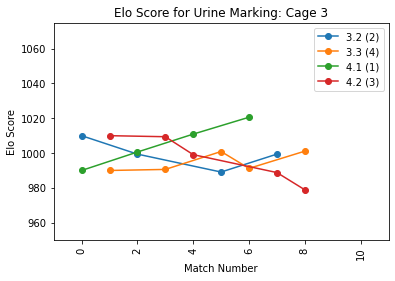

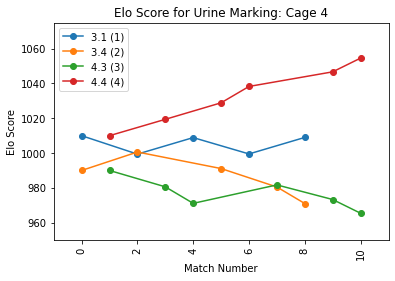

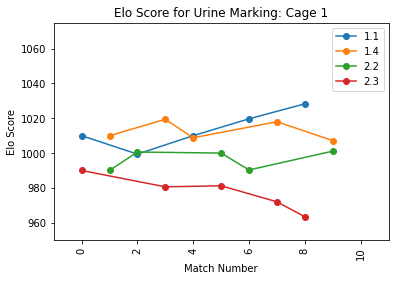

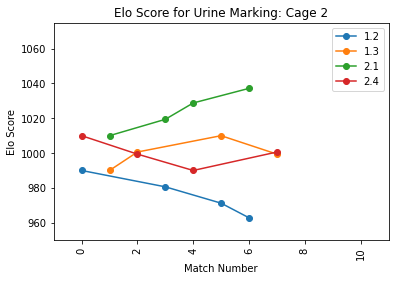

In [51]:
# Plotting for each cage
for cage in urine_marking_elo_score_df["cage"].unique():
    fig, ax = plt.subplots()
    # Getting all the rows with the current cage number
    cage_df = urine_marking_elo_score_df[urine_marking_elo_score_df["cage"] == cage]
    
    # Plotting a line for each subject
    for subject in sorted(cage_df["subject_id"].unique()):
        # Getting all the rows with the current subject
        subject_df = cage_df[cage_df["subject_id"] == subject]
        # Making the dates into days after the first session by subtracting all the dates by the first date
        ax.plot(subject_df["match_number"], subject_df["updated_elo_score"], '-o', label=subject)
    
    
    
    # Setting the Y-Axis to only plot from 0 to 30 because we adjusted the latency to always be under 30
#     ax.set_ylim(0, 1)
    # Labeling the X/Y Axis and the title
    ax.set_xlabel("Match Number")
    ax.set_ylabel("Elo Score")
    ax.set_title("Elo Score for Urine Marking: Cage {}".format(cage))
    # To show the legend
    ax.legend()
    plt.xticks(rotation=90)
    plt.ylim(950, 1075)
    plt.xlim(-1,11)
    file_name = "urine_marking_elo_score_cage_{}_date_{}_{}.png".format(cage, earliest_date, latest_date)
    plt.savefig(os.path.join("./proc/plots/urine_marking", file_name))
